In [38]:
import json 
import numpy as np 
from tqdm import tqdm 
from pathlib import Path
from collections import defaultdict
from transformers import AutoTokenizer 

tokenizer = AutoTokenizer.from_pretrained("t5-base")

def get_prediction(prob_dict):
    predicted_toks_and_probs = []
    all_top_k_idxs = prob_dict['top_logit_idxs'][0]
    all_top_probs = prob_dict['top_logits'][0]
    all_top_probs = [np.exp(x)/np.sum(np.exp(x),keepdims=True) for x in all_top_probs]
    # all_top_toks = tokenizer.batch_decode(all_top_k_idxs) 
    all_top_toks = all_top_k_idxs
    # print(all_top_toks)
    # sys.exit()
    input_str = prob_dict['input_str'][0]

    for timestep in range(len(prob_dict['top_logit_idxs'][0])):
        # best_prob, best_tok = probs[top_k_idxs[0]], toks[top_k_idxs[0]]
        best_prob_idx = np.argmax(all_top_probs[timestep])
        best_tok, best_prob = all_top_toks[timestep][best_prob_idx], all_top_probs[timestep][best_prob_idx]
        predicted_toks_and_probs.append((best_tok, best_prob, all_top_probs[timestep], all_top_toks[timestep]))
    return predicted_toks_and_probs

def check_tokens(pred_tok, tgt_tok, prev_tgts):
    if "SourceCopy" not in pred_tok and "TargetCopy" not in pred_tok:
        return pred_tok == tgt_tok
    elif "SourceCopy" in pred_tok:
        return pred_tok.split("_")[1] == tgt_tok
    else:
        try:
            tok_idx = int(pred_tok.split("_")[1])-1
            return prev_tgts[tok_idx] == tgt_tok
        except IndexError:
            print(len(prev_tgts))
            print(pred_tok)
            print(prev_tgts)
            raise AssertionError
    

def read_json(path): 
    print(f"opening data")
    with open(path) as f1:
        data = [json.loads(l) for l in f1]
    print(f"got data")
    return data

def get_probs(data):
    probs_to_ret = defaultdict(list)
    func_ontology = set()

    mistakes, corrects = [], []

    for instance_idx, prob_dict in tqdm(enumerate(data)): 

        # left_context = [x[0] for x in instance['left_context']][1:]
        # probs = instance['prob_dist']
        predicted_toks = get_prediction(prob_dict)
        source_tokens = prob_dict['input_str'][0]
        left_context = [''] + prob_dict['labels'][0]
        target_toks = left_context + ["@end@"]
        left_context_str = tokenizer.batch_decode(left_context)[0]
        for i in range(len(prob_dict['top_logit_idxs'][0])):
            input_token = left_context[i]
            output_token, output_prob, top_k_probs, top_k_tokens = predicted_toks[i]
            target_token = prob_dict['labels'][0][i]
            # tokens_are_equal = check_tokens(output_token, target_token, left_context[:i])
            tokens_are_equal = output_token == target_token
            if not tokens_are_equal:
                mistake = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks,
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "top_k_tokens": top_k_tokens,
                           "top_k_probs": top_k_probs,
                           "target_token": target_token}
                mistakes.append(mistake)
            else:
                correct = {"instance_idx": instance_idx,
                           "source_tokens": source_tokens,
                           "left_context": left_context[0:i],
                           "target_toks": target_toks,
                           "output_token": output_token,
                           "output_prob": output_prob,
                           "top_k_tokens": top_k_tokens,
                           "top_k_probs": top_k_probs,
                           "target_token": target_token}
                corrects.append(correct)

    return mistakes, corrects

In [39]:
data = read_json("/home/estengel/scratch/dockeroutput/t5_3b_losses.jsonl")


opening data
got data


In [40]:
mistakes, corrects = get_probs(data)

1034it [00:01, 845.14it/s]


In [41]:
from collections import Counter
print(len(mistakes))
print(len(corrects))

mistake_examples = len(set([x['instance_idx'] for x in mistakes])) 
correct_examples = len(set([x['instance_idx'] for x in corrects]))

mistake_idxs = [x['instance_idx'] for x in mistakes]
mistake_counter = Counter(mistake_idxs)
mistake_only_once = [x for x in mistake_counter if mistake_counter[x] == 1]
print(f"{len(mistake_only_once)} of {mistake_examples} ({len(mistake_only_once)/mistake_examples*100:.2f}%) examples have one mistake only")
print(f"number of unique failures: {len(mistakes)}")
print("number of failure examples: " +  str(mistake_examples))
print("number of correct examples: " +  str(correct_examples)) 

print(f"accuracy: {correct_examples/(correct_examples+mistake_examples)}")

print(f"mistakes per mistake example: {len(mistakes)/mistake_examples}")


1615
41927
263 of 610 (43.11%) examples have one mistake only
number of unique failures: 1615
number of failure examples: 610
number of correct examples: 1034
accuracy: 0.6289537712895377
mistakes per mistake example: 2.6475409836065573


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 



In [43]:
mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]


print(np.mean(mistake_probs))
print(np.mean(correct_probs))

# prob_df = pd.DataFrame(columns=['prob', 'correct'])
prob_df_data = []
for prob in mistake_probs:
    prob_df_data.append({'prob': prob, 'correct': False}) 
for prob in correct_probs:
    prob_df_data.append({'prob': prob, 'correct': True}) 


prob_df = pd.DataFrame(prob_df_data)





0.9465993915241581
0.9980583684149655


In [44]:
import scipy 
from collections import Counter

values, bin_edges, bin_number = scipy.stats.binned_statistic(prob_df['prob'], 
                                                             prob_df['correct'], 
                                                             statistic='mean', 
                                                             bins=20)
bin_lookup = Counter(bin_number)

    prob_model  prob_correct  count  log_count
0     0.361614      0.000000    NaN   0.000000
1     0.393533      0.000000    NaN   0.000000
2     0.425453      0.333333    NaN   1.098612
3     0.457372      0.000000    NaN   1.098612
4     0.489291      0.444444    NaN   2.890372
5     0.521211      0.514286    NaN   3.555348
6     0.553130      0.354839    NaN   3.433987
7     0.585049      0.459459    NaN   3.610918
8     0.616968      0.500000    NaN   3.332205
9     0.648888      0.485714    NaN   3.555348
10    0.680807      0.564103    NaN   3.663562
11    0.712726      0.483871    NaN   3.433987
12    0.744646      0.542857    NaN   3.555348
13    0.776565      0.425532    NaN   3.850148
14    0.808484      0.533333    NaN   3.806662
15    0.840404      0.516129    NaN   4.127134
16    0.872323      0.512500    NaN   4.382027
17    0.904242      0.500000    NaN   4.584967
18    0.936161      0.990208    NaN  10.228285
19    0.968081      0.932865    NaN   9.631548


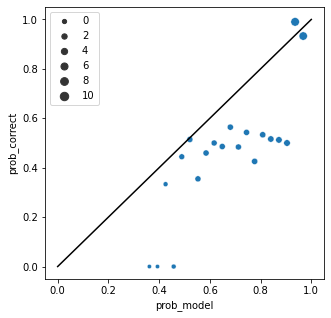

In [45]:
fig, ax = plt.subplots(figsize=(5,5))

df_to_plot = pd.DataFrame(columns=["prob_model", "prob_correct", "count"])
for i, (val, edge, bin_num) in enumerate(zip(values, bin_edges, bin_number)):
    df_to_plot = df_to_plot.append({"prob_model": edge, 
                                    "prob_correct": val, 
                                    "log_count": np.log(bin_lookup[i+1])}, 
                                    ignore_index=True)


sns.scatterplot(data=df_to_plot, x = "prob_model", y="prob_correct", size="log_count", ax=ax, legend='brief')
xs_line = np.linspace(0,1,2)
ys_line = xs_line
sns.lineplot(x = xs_line, y=ys_line, ax=ax, color='black')

print(df_to_plot)

In [ ]:
np.random.seed(12)
# inspect mistakes 
# sample 10 from across the range of mistakes
n_bins = 20
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i]
    if len(bin_mistakes) == 0:
        print(i)
        print(bin_number[0:10])

    mistake = np.random.choice(bin_mistakes, size=1)[0]
    print(f"Source: {mistake['source_tokens']}")
    print(f"Left context: {mistake['left_context']}")
    print(f"TARGET: {mistake['target_toks']}")
    print(f"PRED TOK {mistake['output_token']}")
    print(f"TOP PREDS: {mistake['top_k_tokens']}")
    print(f"TOP PROBS: {mistake['top_k_probs']}")
    print(f"TRUE TARGET: {mistake['target_token']}")
    print("")


In [ ]:
import scipy
from scipy import stats
np.random.seed(12)
# lets look at inputs for 100 mistakes 
n_bins = 100
values, bins, bin_number = scipy.stats.binned_statistic([x['output_prob'] for x in mistakes], [x['output_prob'] for x in mistakes], statistic='mean', bins=n_bins)

for i in range(1, len(bins)):
    bin_mistakes = [x for j, x in enumerate(mistakes) if bin_number[j] == i and mistake_counter[x['instance_idx']] == 1]
    if len(bin_mistakes) == 0:
        continue
    mistake = np.random.choice(bin_mistakes, size=1)[0]
    utt = mistake['source_tokens'].split("__User")[-1]
    print(f"{utt}, {mistake['output_token']}, {mistake['target_token']}, {mistake['output_prob']:.3f}")

In [ ]:
# What percentage of mistakes are low probability? 
# What percentage of correct are high probability? 

mistake_probs = [x['output_prob'] for x in mistakes]
correct_probs = [x['output_prob'] for x in corrects]
correct_probs = np.random.choice(correct_probs, size = len(mistake_probs), replace=False)
fig, ax = plt.subplots(2,1, figsize=(5,5), sharex=False, sharey=False)
sns.histplot(mistake_probs, ax=ax[0], binwidth=0.001)
sns.histplot(correct_probs, ax=ax[1], binwidth=0.001)
ax[0].set_xlim(0.0, 1.0)
ax[1].set_xlim(0.995, 1.0)



In [ ]:
# what's the optimal threshold? 

def compute_f1(df, thresh, downsample=True, min_sample_size=1000):
    pred_mistakes = df[df['prob'] < thresh]
    pred_corrects = df[df['prob'] >= thresh]
    if len(pred_mistakes) < min_sample_size or len(pred_corrects) < min_sample_size:
        return [0, 0, 0, 0]
    if downsample:
        min_len = min(len(pred_mistakes), len(pred_corrects))
        pred_mistakes = pred_mistakes.sample(n=min_len, replace=False)
        pred_corrects = pred_corrects.sample(n=min_len, replace=False)


    false_negatives = len(pred_mistakes[pred_mistakes['correct'] == True])
    false_positives = len(pred_corrects[pred_corrects['correct'] == False])
    true_positives = len(pred_corrects[pred_corrects['correct'] == True])
    true_negatives = len(pred_mistakes[pred_mistakes['correct'] == False])
    try:
        precision = true_positives/(true_positives + false_positives)
    except ZeroDivisionError:
        precision = 0
    try:
        recall = true_positives/(true_positives + false_negatives)
    except ZeroDivisionError:
        recall = 0
    try:
        f1 = 2*precision*recall/(precision + recall)
    except ZeroDivisionError:
        f1 = 0


    accuracy = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
    return [f1, precision, recall, accuracy]

threshes = np.arange(0.00, 1.0, 0.01)
f1s = [[thresh] + compute_f1(prob_df, thresh) for thresh in threshes]

# why is this so low, seems like 0.49 misses most of the true negatives
# F1 score doesn't take true negatives into account; since there are a lot more correct than mistake, 
# maybe classifying everything as correct isn't that bad
# we get 0.0.98 precision, 1.0 recall by setting threshold to 0.0; that's not good 
best_thresh_f1, *best_f1 = max(f1s, key=lambda x: x[1])
best_thresh_acc, *best_acc = max(f1s, key=lambda x: x[-1])
print("f1", best_thresh_f1, best_f1)
print(f"accuracy", best_thresh_acc, best_acc)


# so anything less than 0.995 confidence can safely be said to be a mistake, with 0.94 F1 (pretty good), super high precision, lower recall 

In [ ]:
print(len(prob_df))